## Simple RNN language model to predict plausible dinosaur names - part 2

As described in the initial notebook, this notebook is aimed towards completing the analysis of the 3,4,5 types of models to see what the optimal performance model is. Given the performance from the first notebook I will be using the cost architecture from MODEL 1. My overall conclusion is that my initial set lr was too high and it was not allowing my model to effectively learn. Further, I found that a midsized input sequence led to the best performance and that a dense layer before the softmax output increased performance as well.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import latex
from sklearn.utils import shuffle
np.random.seed(10)

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Data preprocessing - copy of last notebook

In [2]:
# Reading in data - creating dictionaries specifying how to encode data (into characters)
chars = []
all_names = []
with open("../../data/dino_names/names.txt") as names:
    lines = names.readlines()
    for line in lines:
        line = line.lower()
        for char in line:
            if char not in chars:
                chars.append(char)
        all_names.append(line) # \n included
                
print(chars)
print("no chars:",len(chars))

['a', 'c', 'h', 'e', 'n', 'o', 's', 'u', 'r', '\n', 'd', 'y', 'x', 'b', 'l', 'i', 't', 'p', 'v', 'm', 'g', 'f', 'j', 'k', 'w', 'z', 'q']
no chars: 27


In [3]:
# Analysis of the names set
print(len(all_names))
print("max char len:", len(max(all_names,key=len)))
print("min char len:", len(min(all_names,key=len)))

1536
max char len: 27
min char len: 4


In [4]:
# Creating encoder and decoder
i = 1
encoder = {"\n":0} # char to id, set \n to be 0
decoder = {0:"\n"} # id to char

for char in chars:
    if char != "\n":
        encoder[char] = i
        decoder[i] = char
        i += 1

In [5]:
# returns one hot encoding for a particular character
def get_one_hot_encoding(char):
    char_enc = encoder[char]
    hot_vec = np.zeros((27,1)) # vocab_size = 27
    hot_vec[char_enc] = 1
    hot_vec = hot_vec.T # shape (1,27)
    return hot_vec

In [18]:
# Returns the one_hot_encoding representation for a set of characters, i.e. "abc"
def get_character_encoding(chars,ishape=3):
    ret_enc = []
    for c in chars:
        c_one_hot = get_one_hot_encoding(c) # one_hot_encoding
        ret_enc.append(c_one_hot)
        
    ret_enc = np.array(ret_enc)
    ret_enc.shape = (ishape,27)
    return ret_enc

In [7]:
# returns a list of ((3,27),(1,27)) pairs corresponding with ((x_train_set),(y_output))
def get_training_examples(lis_names,seed):
    shuf_names = shuffle(lis_names,random_state=seed) # shuffling order of names
    training_set = []
    
    for name in lis_names:
        m = len(name)
        i = 3
        while i < m: # this means we won't overrun the number of chars in a name
            x_temp = get_character_encoding(name[i-3:i])
            y_temp = get_one_hot_encoding(name[i]) # x^<t+1>
            training_set.append((x_temp,y_temp))
            i += 1
            
    return training_set

In [8]:
# Getting initial training set / testing func.
training_set = get_training_examples(all_names,seed=0)
print("Number of training examples:", len(training_set))
print("x shape:", training_set[100][0].shape)
print("y shape:", training_set[100][1].shape)

Number of training examples: 15301
x shape: (3, 27)
y shape: (1, 27)


### Building MODEL 3 - which uses the cost architecture of MODEL 1 - and has an additional dense layer before the softmax output

In [10]:
# placeholders for model 1
# predicting one word only, so y shape = (1,num_chars)
def get_placeholders():
    X = tf.placeholder(tf.float32, shape=[3, 27], name='X')
    y = tf.placeholder(tf.float32, shape=[1, 27], name='Y')
    return X,y

In [11]:
# Defining the rnn block with lstm cells for model 3 - uses dense layer w/ tanh activation
def rnn_cell3(the_input,n_input=3):
    the_input = tf.split(the_input, n_input, axis=0) # create subtensor for each char
    rnn_cell = tf.nn.rnn_cell.LSTMCell(num_units=512,activation=tf.nn.tanh)
    outputs, curr_state = tf.nn.static_rnn(rnn_cell,inputs=the_input,dtype=tf.float32)
    
    flat = tf.layers.flatten(outputs[-1]) # flatten last activation from lstm
    dense = tf.layers.dense(flat,100,activation=tf.nn.tanh,kernel_initializer=tf.contrib.layers.xavier_initializer())
    out = tf.layers.dense(dense,27,activation=None,kernel_initializer=tf.contrib.layers.xavier_initializer()) # logits
    return out # returns logits

In [12]:
# cost function used for all models moving forward
def cost_function(logits,y):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y,logits=logits))

In [13]:
# Testing rnn cells and cost function for model 3
tf.reset_default_graph()
x,y = get_placeholders()
logits = rnn_cell3(x)
cost = cost_function(logits,y)

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    acost = sess.run(cost,feed_dict={x:training_set[100][0],y:training_set[100][1]})
    print(acost)

3.281639


In [60]:
# Model for language model using stochastic gradient descent w/ gradient clipping
# Note - this model builds the computation graph for model 3, model 4, model 5
def model(names_set,lr=0.01,num_epochs=15,retrain=True,model_n="model3"):
    tf.reset_default_graph() # resetting graph
    tf.set_random_seed(1)
    seed=0
    costs=[]
    
    if model_n == "model3":
        x,y = get_placeholders()
        logits = rnn_cell3(x)
    elif model_n == "model4": # using model 2
        x,y = get_placeholders4()
        logits = rnn_cell3(x,n_input=4)
    else: # model 5
        x,y = get_placeholders4()
        logits = rnn_cell5(x,n_input=4)
        
    cost = cost_function(logits,y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate=lr)
    grads, variables = zip(*optimizer.compute_gradients(cost))
    grads, _ = tf.clip_by_global_norm(grads, 5.0) # gradient clipping
    optimizer = optimizer.apply_gradients(zip(grads, variables))
    
    init = tf.global_variables_initializer()
    saver = tf.train.Saver() # to save/load model
    with tf.Session() as sess:
        if retrain:
            if model_n == "model3": # use model 1 to continue training
                saver = tf.train.import_meta_graph("../../data/dino_names/model3/language_model.ckpt.meta")
                saver.restore(sess, "../../data/dino_names/model3/language_model.ckpt")
            elif model_n == "model4": # use model 2 to continue training
                saver = tf.train.import_meta_graph("../../data/dino_names/model4/language_model.ckpt.meta")
                saver.restore(sess, "../../data/dino_names/model4/language_model.ckpt")
            else: # model 5
                saver = tf.train.import_meta_graph("../../data/dino_names/model5/language_model.ckpt.meta")
                saver.restore(sess, "../../data/dino_names/model5/language_model.ckpt")
        else:
            sess.run(init) # only run init when you are training a new model

        for epoch in range(num_epochs):
            old_running_cost = 0 # used to print out the increase to total cost each step
            running_cost = 0
            seed += 1
            if model_n == "model3":
                training_set = get_training_examples(names_set,seed)
            elif model_n == "model4":
                training_set = get_training_examples4(names_set,seed)
            else: # model 5
                training_set = get_training_examples4(names_set,seed)
                
            for aset in training_set:
                (ax,ay) = aset
                _,temp_cost = sess.run([optimizer,cost], feed_dict={x:ax,y:ay})
                running_cost += temp_cost
                
            costs.append(running_cost)
            if (epoch+1) % 1 == 0: # printing costs
                print("Cost at epoch {}: {}".format(epoch+1,running_cost))
                # model saved on every iteration
                if model_n == "model3":
                    loc = saver.save(sess, "../../data/dino_names/model3/language_model.ckpt")
                elif model_n == "model4":
                    loc = saver.save(sess, "../../data/dino_names/model4/language_model.ckpt")
                else: # model 5
                    loc = saver.save(sess, "../../data/dino_names/model5/language_model.ckpt")

        return costs

In [25]:
# I chose a different number of training steps as the standard approach would have led to divergence
acosts3_1 = model(all_names,lr=0.01,num_epochs=13,retrain=False,model_n="model3")

Cost at epoch 1: 28119.10464586968
Cost at epoch 2: 24682.88822403022
Cost at epoch 3: 23539.918142724047
Cost at epoch 4: 22876.409683206606
Cost at epoch 5: 22606.765319740345
Cost at epoch 6: 22396.693825631475
Cost at epoch 7: 22325.538178497118
Cost at epoch 8: 21758.330335539322
Cost at epoch 9: 21396.466091868504
Cost at epoch 10: 21772.1196852814
Cost at epoch 11: 21541.957956359227
Cost at epoch 12: 21171.743624677194
Cost at epoch 13: 20816.849670364467


In [26]:
acosts3_2 = model(all_names,lr=0.001,num_epochs=5,retrain=True,model_n="model3")

INFO:tensorflow:Restoring parameters from ../../data/dino_names/model3/language_model.ckpt
Cost at epoch 1: 18261.07530364884
Cost at epoch 2: 16089.376677761578
Cost at epoch 3: 15376.597761849958
Cost at epoch 4: 14958.221101894527
Cost at epoch 5: 14675.547610226506


In [28]:
acosts3_3 = model(all_names,lr=0.0001,num_epochs=5,retrain=True,model_n="model3")

INFO:tensorflow:Restoring parameters from ../../data/dino_names/model3/language_model.ckpt
Cost at epoch 1: 14382.980015900186
Cost at epoch 2: 13916.668336423836
Cost at epoch 3: 13718.444981583165
Cost at epoch 4: 13600.921183897502
Cost at epoch 5: 13519.678591767142


In [30]:
acosts3_4 = model(all_names,lr=0.00001,num_epochs=3,retrain=True,model_n="model3")

INFO:tensorflow:Restoring parameters from ../../data/dino_names/model3/language_model.ckpt
Cost at epoch 1: 13330.08892276076
Cost at epoch 2: 13320.386157818233
Cost at epoch 3: 13311.513022570638


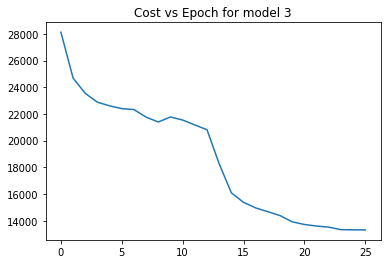

model 3 percentage change: 0.47339747087309625


In [32]:
total_costs3 = acosts3_1 + acosts3_2 + acosts3_3 + acosts3_4
ax_i3 = [i for i in range(len(total_costs3))]
plt.plot(ax_i3,total_costs3)
plt.title("Cost vs Epoch for model 3")
plt.show()
print("model 3 percentage change:",total_costs3[-1]/total_costs3[0])

In [33]:
# This sample cell samples the model in order to create a dinosaur name
def sample_cell(the_input,a,c):
    past_state = (a,c)
    the_input = tf.split(the_input,1,axis=0) # create subtensor for each char
    rnn_cell = tf.nn.rnn_cell.LSTMCell(num_units=512,activation=tf.nn.tanh) # 512 hidden units per cell
    outputs, curr_state = tf.nn.static_rnn(rnn_cell,inputs=the_input,initial_state=past_state,dtype=tf.float32) # output for each input
    
    flat = tf.layers.flatten(outputs[-1]) # flatten last activation from lstm
    dense = tf.layers.dense(flat,100,activation=tf.nn.tanh,kernel_initializer=tf.contrib.layers.xavier_initializer())
    out = tf.layers.dense(dense,27,activation=None,kernel_initializer=tf.contrib.layers.xavier_initializer()) # logits, 27D output
    out = tf.nn.softmax(out)
    achar = tf.argmax(out,axis=-1)
    achar = tf.reshape(achar,()) # character in int representation
    return achar,curr_state # returns logits

In [40]:
# Sampling the characters and ensuring the hidden state is updating each time step, from model 3
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[1, 27])
a = tf.placeholder(tf.float32, shape=[1, 512])
c = tf.placeholder(tf.float32, shape=[1, 512])
out = sample_cell(x,a,c)

ax = get_one_hot_encoding("c")
out_char = -1
i = 0 # counts timesteps

saver = tf.train.Saver()
sess = tf.InteractiveSession()
saver = tf.train.import_meta_graph("../../data/dino_names/model3/language_model.ckpt.meta")
saver.restore(sess, "../../data/dino_names/model3/language_model.ckpt")

print("c") # first character
while out_char != 0 and i < 11:
    if i == 0:
        (achar,past_state) = sess.run(out,feed_dict={x:ax,a:np.zeros((1,512)),c:np.zeros((1,512))})
        out_char = achar
        a_past_state = past_state
    else:
        print("sampled char:",decoder[achar]) # print character
        a_a = past_state[0]
        a_c = past_state[1]
        ax = get_one_hot_encoding(decoder[achar])
        (achar,past_state) = sess.run(out,feed_dict={x:ax,a:a_a,c:a_c})
        out_char = achar
        print("state a difference at " + str(i) + ":",np.sum(np.subtract(a_past_state[0],past_state[0]))) # sanity check
        print("state c difference at " + str(i) + ":",np.sum(np.subtract(a_past_state[1],past_state[1])))
        a_past_state = past_state
        
    i += 1

INFO:tensorflow:Restoring parameters from ../../data/dino_names/model3/language_model.ckpt
c
sampled char: r
state a difference at 1: -2.7144313
state c difference at 1: -0.11834049
sampled char: a
state a difference at 2: 2.0354805
state c difference at 2: 0.64591444
sampled char: t
state a difference at 3: -3.50314
state c difference at 3: -0.040999427
sampled char: o
state a difference at 4: -9.135405
state c difference at 4: -0.79870915
sampled char: s
state a difference at 5: 4.8003073
state c difference at 5: 0.86166877
sampled char: a
state a difference at 6: 1.3442166
state c difference at 6: -1.1419038
sampled char: u
state a difference at 7: 1.9743168
state c difference at 7: 1.801465
sampled char: r
state a difference at 8: 3.0045896
state c difference at 8: -2.3951216
sampled char: o
state a difference at 9: 6.1986084
state c difference at 9: -0.9192736
sampled char: s
state a difference at 10: -2.8639412
state c difference at 10: 13.653273


### Building MODEL 4 - which uses a dense layer with 100 units before the softmax layer and now uses sequences of length 4 rather than 3 to see if there is a performance boost with longer input sequences

The dense layer was found to make the gradient smoother and also improve the overall training and optimization performance. Note - this means that names that have a length less than 5 will be ignored. Also it should be noted that I initially tried a sequence length of 5 but found that to be highly ineffective.

In [43]:
# placeholders for model 1
# predicting one word only, so y shape = (1,num_chars)
def get_placeholders4():
    X = tf.placeholder(tf.float32, shape=[4, 27], name='X')
    y = tf.placeholder(tf.float32, shape=[1, 27], name='Y')
    return X,y

In [44]:
# returns a list of ((5,27),(1,27)) pairs corresponding with ((x_train_set),(y_output))
# This corresponds with MODEL 5
def get_training_examples4(lis_names,seed):
    shuf_names = shuffle(lis_names,random_state=seed) # shuffling order of names
    training_set = []
    
    for name in lis_names:
        m = len(name)
        if m >= 5: # ignore names that are too short
            i = 4
            while i < m: # this means we won't overrun the number of chars in a name
                x_temp = get_character_encoding(name[i-4:i],4)
                y_temp = get_one_hot_encoding(name[i]) # x^<t+1>
                training_set.append((x_temp,y_temp))
                i += 1
            
    return training_set

In [45]:
# Testing new traing examples function for model 4
training_set4 = get_training_examples4(all_names,seed=0)
print("Number of training examples:", len(training_set4))
print("x shape:", training_set4[100][0].shape)
print("y shape:", training_set4[100][1].shape)

Number of training examples: 13765
x shape: (4, 27)
y shape: (1, 27)


In [48]:
acosts4_1 = model(all_names,lr=0.005,num_epochs=13,retrain=False,model_n="model4")

Cost at epoch 1: 22031.760993168184
Cost at epoch 2: 18458.060904262136
Cost at epoch 3: 16806.202032723548
Cost at epoch 4: 15339.331320494503
Cost at epoch 5: 14054.86121266467
Cost at epoch 6: 12775.282201337948
Cost at epoch 7: 11852.643405871586
Cost at epoch 8: 11248.6722918388
Cost at epoch 9: 10816.88454346093
Cost at epoch 10: 10655.181507300893
Cost at epoch 11: 10236.20877039611
Cost at epoch 12: 10193.541512789914
Cost at epoch 13: 9988.611908869489


In [49]:
acosts4_2 = model(all_names,lr=0.0005,num_epochs=5,retrain=True,model_n="model4")

INFO:tensorflow:Restoring parameters from ../../data/dino_names/model4/language_model.ckpt
Cost at epoch 1: 9966.989500515409
Cost at epoch 2: 6736.570996250002
Cost at epoch 3: 5845.386564075365
Cost at epoch 4: 5442.366508625973
Cost at epoch 5: 5228.997070315792


In [50]:
acosts4_3 = model(all_names,lr=0.00005,num_epochs=5,retrain=True,model_n="model4")

INFO:tensorflow:Restoring parameters from ../../data/dino_names/model4/language_model.ckpt
Cost at epoch 1: 5196.347926332022
Cost at epoch 2: 4802.712599944936
Cost at epoch 3: 4595.480441101919
Cost at epoch 4: 4470.490718779306
Cost at epoch 5: 4387.000201146346


In [51]:
acosts4_4 = model(all_names,lr=0.00001,num_epochs=5,retrain=True,model_n="model4")

INFO:tensorflow:Restoring parameters from ../../data/dino_names/model4/language_model.ckpt
Cost at epoch 1: 4274.045278612893
Cost at epoch 2: 4257.898329842668
Cost at epoch 3: 4242.871365139809
Cost at epoch 4: 4228.926574189046
Cost at epoch 5: 4215.939390218729


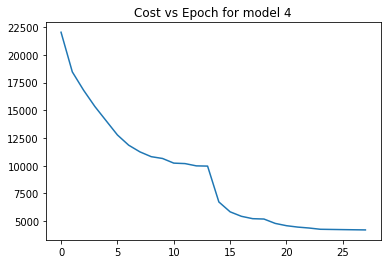

model 4 percentage change: 0.19135734957936626


In [52]:
# This was a relatively very smooth gradient and thus far the highest performing model
total_costs4 = acosts4_1 + acosts4_2 + acosts4_3 + acosts4_4
ax_i4 = [i for i in range(len(total_costs4))]
plt.plot(ax_i4,total_costs4)
plt.title("Cost vs Epoch for model 4")
plt.show()
print("model 4 percentage change:",total_costs4[-1]/total_costs4[0])

In [56]:
# Sampling the characters and ensuring the hidden state is updating each time step, from model 4
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[1, 27])
a = tf.placeholder(tf.float32, shape=[1, 512])
c = tf.placeholder(tf.float32, shape=[1, 512])
out = sample_cell(x,a,c)

ax = get_one_hot_encoding("t")
out_char = -1
i = 0 # counts timesteps

saver = tf.train.Saver()
sess = tf.InteractiveSession()
saver = tf.train.import_meta_graph("../../data/dino_names/model4/language_model.ckpt.meta")
saver.restore(sess, "../../data/dino_names/model4/language_model.ckpt")

print("t") # first character
while out_char != 0:
    if i == 0:
        (achar,past_state) = sess.run(out,feed_dict={x:ax,a:np.zeros((1,512)),c:np.zeros((1,512))})
        out_char = achar
        a_past_state = past_state
    else:
        print(decoder[achar]) # print character
        a_a = past_state[0]
        a_c = past_state[1]
        ax = get_one_hot_encoding(decoder[achar])
        (achar,past_state) = sess.run(out,feed_dict={x:ax,a:a_a,c:a_c})
        out_char = achar
        #print("state a difference at " + str(i) + ":",np.sum(np.subtract(a_past_state[0],past_state[0]))) # sanity check
        #print("state c difference at " + str(i) + ":",np.sum(np.subtract(a_past_state[1],past_state[1])))
        a_past_state = past_state
        
    i += 1

INFO:tensorflow:Restoring parameters from ../../data/dino_names/model4/language_model.ckpt
t
h
o
l
u
s


### Building MODEL 5 - based on the comparatively outstanding performance from model 4, model 5 will use a dense layer w/ length 4 input sequences, lr=0.005 starting and will use standard rnn cells without memory gates

In [57]:
# Using standatd rnn cells 
def rnn_cell5(the_input,n_input=4):
    the_input = tf.split(the_input, n_input, axis=0) # create subtensor for each char
    rnn_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=512,activation=tf.nn.tanh)
    outputs, curr_state = tf.nn.static_rnn(rnn_cell,inputs=the_input,dtype=tf.float32)
    
    flat = tf.layers.flatten(outputs[-1]) # flatten last activation from lstm
    dense = tf.layers.dense(flat,100,activation=tf.nn.tanh,kernel_initializer=tf.contrib.layers.xavier_initializer())
    out = tf.layers.dense(dense,27,activation=None,kernel_initializer=tf.contrib.layers.xavier_initializer()) # logits
    return out # returns logits

In [58]:
# Testing rnn cells and cost function for model 5
tf.reset_default_graph()
x,y = get_placeholders4()
logits = rnn_cell5(x)
cost = cost_function(logits,y)

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    acost = sess.run(cost,feed_dict={x:training_set4[100][0],y:training_set4[100][1]})
    print(acost)

3.4748602


In [63]:
acosts5_1 = model(all_names,lr=0.0001,num_epochs=13,retrain=False,model_n="model5")

Cost at epoch 1: 24555.917863879353
Cost at epoch 2: 21883.042540550698
Cost at epoch 3: 21276.668862056336
Cost at epoch 4: 20688.92791122629
Cost at epoch 5: 20058.541762511362
Cost at epoch 6: 19464.79265206994
Cost at epoch 7: 18938.302535669704
Cost at epoch 8: 18466.502566482726
Cost at epoch 9: 18044.938780543394
Cost at epoch 10: 17673.959982830434
Cost at epoch 11: 17351.822750971973
Cost at epoch 12: 17053.454431724458
Cost at epoch 13: 16769.461917686145


In [65]:
acosts5_2 = model(all_names,lr=0.0001,num_epochs=20,retrain=True,model_n="model5")

INFO:tensorflow:Restoring parameters from ../../data/dino_names/model5/language_model.ckpt
Cost at epoch 1: 15916.214103656686
Cost at epoch 2: 15678.257254178538
Cost at epoch 3: 15401.017784358322
Cost at epoch 4: 15141.079871492759
Cost at epoch 5: 14908.165333490222
Cost at epoch 6: 14629.25554901026
Cost at epoch 7: 14331.34552031882
Cost at epoch 8: 14033.510031507216
Cost at epoch 9: 13704.141754718337
Cost at epoch 10: 13439.21299905855
Cost at epoch 11: 13192.81241386915
Cost at epoch 12: 12924.96341347342
Cost at epoch 13: 12670.902871248869
Cost at epoch 14: 12462.809615293778
Cost at epoch 15: 12269.858070615777
Cost at epoch 16: 12000.9627952749
Cost at epoch 17: 11742.220508183946
Cost at epoch 18: 11409.828158060676
Cost at epoch 19: 11160.300550180902
Cost at epoch 20: 10943.87613020537


In [66]:
acosts5_3 = model(all_names,lr=0.0001,num_epochs=50,retrain=True,model_n="model5")

INFO:tensorflow:Restoring parameters from ../../data/dino_names/model5/language_model.ckpt
Cost at epoch 1: 10662.862451610972
Cost at epoch 2: 10597.05927763485
Cost at epoch 3: 10273.30966259607
Cost at epoch 4: 10039.466317098344
Cost at epoch 5: 9734.057546342416
Cost at epoch 6: 9578.45297750223
Cost at epoch 7: 9471.057693486524
Cost at epoch 8: 9322.559418350473
Cost at epoch 9: 9155.70826961142
Cost at epoch 10: 8965.732786358163
Cost at epoch 11: 8798.806581916102
Cost at epoch 12: 8720.403263411063
Cost at epoch 13: 8430.064076490718
Cost at epoch 14: 8178.9528367946605
Cost at epoch 15: 8164.49293423518
Cost at epoch 16: 7982.811914235273
Cost at epoch 17: 7832.328959268354
Cost at epoch 18: 7699.799669234322
Cost at epoch 19: 7488.421987246722
Cost at epoch 20: 7429.994954747851
Cost at epoch 21: 7277.3789349400595
Cost at epoch 22: 7201.137158562956
Cost at epoch 23: 7254.222656658403
Cost at epoch 24: 7033.9572474213
Cost at epoch 25: 6993.33145114219
Cost at epoch 26: 69

In [67]:
acosts5_4 = model(all_names,lr=0.00001,num_epochs=50,retrain=True,model_n="model5")

INFO:tensorflow:Restoring parameters from ../../data/dino_names/model5/language_model.ckpt
Cost at epoch 1: 10498.867150067967
Cost at epoch 2: 7918.304069678139
Cost at epoch 3: 7139.064142230756
Cost at epoch 4: 6738.801499603137
Cost at epoch 5: 6484.377004305677
Cost at epoch 6: 6300.491067524029
Cost at epoch 7: 6161.3440720377
Cost at epoch 8: 6052.960677893685
Cost at epoch 9: 5967.249535194571
Cost at epoch 10: 5897.688194335353
Cost at epoch 11: 5839.485806824008
Cost at epoch 12: 5789.261300505138
Cost at epoch 13: 5745.055365237539
Cost at epoch 14: 5706.541338059933
Cost at epoch 15: 5672.8501626107645
Cost at epoch 16: 5643.798734126665
Cost at epoch 17: 5618.2503281443405
Cost at epoch 18: 5595.704408095829
Cost at epoch 19: 5575.577550888121
Cost at epoch 20: 5555.539786556659
Cost at epoch 21: 5536.91016442293
Cost at epoch 22: 5519.891416772001
Cost at epoch 23: 5504.358975355745
Cost at epoch 24: 5490.362196226945
Cost at epoch 25: 5477.635542677751
Cost at epoch 26: 

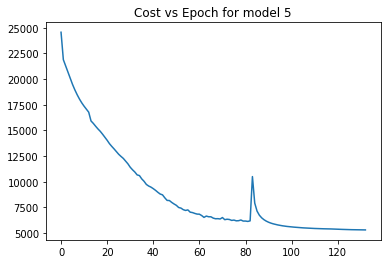

model 5 percentage change: 0.21601420461950846


In [68]:
total_costs5 = acosts5_1 + acosts5_2 + acosts5_3 + acosts5_4
ax_i5 = [i for i in range(len(total_costs5))]
plt.plot(ax_i5,total_costs5)
plt.title("Cost vs Epoch for model 5")
plt.show()
print("model 5 percentage change:",total_costs5[-1]/total_costs5[0])